In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import json
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
import torch
import torchtext
from torchtext.data import Field, LabelField
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator
import spacy
import en_core_web_sm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import time
from collections import Counter

path = "/content/drive/My Drive/Colab Notebooks/data/"


In [0]:
#!pip install -U torch

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0)


In [0]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


#EDA

In [0]:
# reading in 50k data
df = pd.read_csv(path+"subset_100k.csv", index_col=0, encoding="utf-8").reset_index(drop=True)
# df_shuffled = df.sample(frac=1, random_state=123) #shuffle rows randomly
# df_shuffled = df_shuffled.drop(columns="index") #drops index to only keep text and label
train, validate, test = np.split(df.sample(frac=1, random_state=123).drop(columns="index"), 
                                                                          [int(.6*len(df)), int(.8*len(df))])
train_texts, train_labels = zip(*train.values) #resulting type is tuples
valid_texts, valid_labels = zip(*validate.values)
test_texts, test_labels = zip(*test.values)

In [0]:
#check distribution of shuffled data by class (random state 123)

print(Counter(train_labels))
print(Counter(valid_labels))
print(Counter(test_labels))

Counter({0: 30118, 1: 29882})
Counter({1: 10124, 0: 9876})
Counter({0: 10006, 1: 9994})


In [0]:
print(train[:3])
print(train[-3:])

                                                    text  labels
42083  MUMBAI: India's star professional boxer and Ol...       0
71825  P.S: This may not seem like something that is ...       1
99535  This pattern is available\n\nThe pattern is fr...       1
                                                    text  labels
20737  Ohio Gov. John Kasich is continuing his attack...       0
37688  This page has been flagged for a review of its...       0
83502  An Ottawa family is speaking out after a photo...       1


In [0]:
print(validate[:3])
print(validate[-3:])

                                                    text  labels
75082  A recent study has found that children are mor...       1
88345  Greetings Friends,\n\n\nI hope everyone is cel...       1
95838  The UESPWiki – Your source for The Elder Scrol...       1
                                                    text  labels
89728  The Washington Post reports this week that the...       1
32245  Climate Change Protesters Canceled March in Co...       0
4458   When Canadiens general manager Marc Bergevin s...       0


In [0]:
print(test[:3])
print(test[-3:])

                                                    text  labels
21563  According to local services' estimates, about ...       0
67879  "I feel extremely lucky that I was at the righ...       1
86351  The Department of Homeland Security (DHS) is t...       1
                                                    text  labels
17730  Just checked into the speaker forum to look fo...       0
28030  SHOWCASE ! That Bastard Is Trying To Steal Our...       0
15725  Touch Of Malice Check List\n\nMausoleum\n\n1\n...       0


In [0]:
#create train, val, test subsets from 50k subset

# train.to_csv(path+"subset_50k_train.csv", index=False)
# validate.to_csv(path+"subset_50k_valid.csv", index=False)
# test.to_csv(path+"subset_50k_test.csv", index=False)

In [0]:
print(len(train))
print(len(validate))
print(len(test))

print(len(train_texts))
print(len(valid_texts))
print(len(test_texts))

60000
20000
20000
60000
20000
20000


In [0]:
pd.set_option('display.max_colwidth',1000)

sub_val = validate[validate.labels==0]

# print(validate.text.str.len())

# print(validate.text.str.len().sort_values())

s = sub_val.text.str.len().sort_values().index
df1 = sub_val.reindex(s)
df1 = df1.reset_index(drop=True)
print(df1.head(10))
print(df1.text.str.len().head(10))

                                                                                                                                                                                                                        text  labels
0                  We're taking one for the team today in order to make shopping here better.While you wait, read our blog , or check @FinishLine on Instagramand stay up to speed on all things sneakers, style, and sport.       0
1              Goal 3: Cut the unemployment rate among young people in half within 3 years. 15 Goals to Rebuild the American Dream\n\nThe unemployment rate for young people aged 16 to 24 is above 14 percent.\n\nRead More       0
2                  Molly Dorozenski, Greenpeace USA joins Thom. Hillary Clinton says that Bernie Sanders is lying when he says that her campaign accepts money from the fossil fuel industry. But what about her Super PACs?       0
3                Scientists can now visualize and experiment with structures and dyn

In [0]:
short_string = sub_val[sub_val.text.str.contains("Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs")].text

In [0]:
long_string = sub_val[sub_val.text.str.contains("Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs")].text


In [0]:
long_string = long_string.to_string()[8:]

In [0]:
long_string2 = sub_val[sub_val.text.str.contains("If you look on a board game shelf, how many games will you see with actions based on collaboration")].text
long_string2 = long_string2.to_string()[9:]

TypeError: ignored

# Load and prepare dataset for pytorch

In [0]:
# spacy_en = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner","textcat"])
# spacy_en.add_pipe(spacy_en.create_pipe('sentencizer')) #adding sentence tokenizer

spacy_en = spacy.load('en_core_web_sm') #changed syntax?

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = Field(sequential=True, tokenize=tokenize_en, lower=True)
LABEL = Field(sequential=False, unk_token = None)


In [0]:
#100k subset
train, val, test = TabularDataset.splits(
               path=path, # the root directory where the data lies
               train='subset_100k_train.csv', validation="subset_100k_valid.csv", test="subset_100k_test.csv", # file names
               format='csv',
               skip_header=True, 
               fields=[('text', TEXT), ('label', LABEL)])

In [0]:
#100k subset

TEXT.build_vocab(train, min_freq=1)
LABEL.build_vocab(train)

print("Vocabulary size of TEXT:",len(TEXT.vocab.stoi))
print("Vocabulary size of LABEL:",len(LABEL.vocab.stoi))

Vocabulary size of TEXT: 296067
Vocabulary size of LABEL: 2


In [0]:
#100k subset

TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

print("Vocabulary size of TEXT:",len(TEXT.vocab.stoi))
print("Vocabulary size of LABEL:",len(LABEL.vocab.stoi))

Vocabulary size of TEXT: 145549
Vocabulary size of LABEL: 2


In [0]:
train_iter, val_iter = BucketIterator.splits( 
 (train, val), 
 batch_sizes=(64,256),
 sort_key=lambda x: len(x.text), 
 sort=True,
 device=device,
 sort_within_batch=True
)

test_iter = Iterator(
    test,
    batch_size=(256),
    sort_key=lambda x: len(x.text),
    sort=False,
    shuffle=False)

In [0]:
# create a single batch and terminate the loop
i = 0
for batch in val_iter:
    texts = batch.text
    labels = batch.label
    print(i)
    print(texts)
    print(labels)
    i+=1
    if i ==3:
      break

    #break  #we use first batch as an example.
    
print('texts:', texts.shape)
print('labels:', labels.shape)

# texts: [length, batch size]
# labels: [batch size]

0
tensor([[    2,    11,    14,  ...,     0,    21, 11695],
        [  156,    24,    13,  ...,     8,   115,  2534],
        [    6,    13,   266,  ..., 17087,   101,  1805],
        ...,
        [  152,  9754,  2035,  ...,     1,     1,     1],
        [ 1035,     4,  1538,  ...,     1,     1,     1],
        [    4,    11,     4,  ...,     1,     1,     1]])
tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,

# CNN baseline

In [0]:
# To define a CNN class
class CNN_Text(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, output_size, kernel_num, region_sizes, dropout):
        '''
        vocabulary_size: vocabulary size
        embedding_dim: word embedding size
        output_size: number of classes in prediction
        kernel_num: number of kernels (number of output channels of convolutional layers)
        region_sizes: height of kernels of convolutional layers
        dropout: dropout rate
        '''
        super(CNN_Text, self).__init__()
        # the size of input channel is 1.
        Ci = 1
        
        # word embedding layer
        self.embeddings = nn.Embedding(num_embeddings = vocabulary_size, embedding_dim = embedding_dim )
        
        # convolution with kernels
        self.convolution_layers = nn.ModuleList([nn.Conv2d(in_channels = Ci, out_channels = kernel_num, kernel_size = (K, embedding_dim)) for K in region_sizes])
        
        # a dropout layer
        self.dropout = nn.Dropout(dropout) 
        
        # fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * kernel_num, output_size)

    def forward(self, x):
        # input x  [sequence length, batch size]
        
        input_embeddings = self.embeddings(x)  
        # (batch size, word_sequence, embedding_dim) word embedding

        input_embeddings = input_embeddings.permute(1,0,2)
        input_embeddings = input_embeddings.unsqueeze(1)
        #  [batch size, number of channel is one, sequence length, embeeding size]

        # convolutional layers
        convolute_outputs = [F.relu(conv(input_embeddings)).squeeze(3) for conv in self.convolution_layers]  
        
        # to get the maximum value of filtered tensor
        max_pooling_outputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in convolute_outputs] 
        
        concat_list = torch.cat(max_pooling_outputs, 1) # concatenate representations
        
        drop_output = self.dropout(concat_list)  # add drop layer
        
        fc1_output = self.fc(drop_output)  # get the fc1 using a fully connected layer
        
        final_output = F.softmax(fc1_output,dim=1)
        
        return final_output


In [0]:
# Hyper Parameters

# the vocabulary size
vocabulary_size = len(TEXT.vocab.stoi) 

# Dimension of word embedding is 300. Namely, each word is expressed by a vector that has 300 dimensions.
embedding_dim = 300 

# region size as 2, 3, and 4
kernel_sizes = [2,3,4] 

# the number of kernel in each region size
kernels_num = 32  

# The dropout rate is set to be 0.5.
dropout = 0.5

# The output size of labels.
output_size = 2

# learning rate is set to be 0.01. CHANGED FROM ORIGINAL
lr = 0.0001        

# The number of iteration is set to be 5.
num_epoch = 5  

# employ class CNN_Text and assign to cnn
model = CNN_Text(vocabulary_size, embedding_dim, output_size, kernels_num, kernel_sizes, dropout).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.1)
        else:
            nn.init.constant_(param.data, 0)
            
#model.apply(init_weights)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 43,929,290 trainable parameters


In [0]:
#second run

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 43,751,390 trainable parameters


In [0]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)   # define a optimizer for backpropagation
loss_func = nn.CrossEntropyLoss()   # define loss funtion

In [0]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        batch_input, labels = batch.text, batch.label
        batch_input = batch_input.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(batch_input)

        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.cpu().item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            batch_input, labels = batch.text, batch.label
            batch_input = batch_input.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_input)

            loss = criterion(outputs, labels)

            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
  
    
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
len(val_iter)

40

In [0]:
# 100k subset
MAX_EPOCH = 20
total_step = len(train_iter)
loss_list = []
acc_list = []

for epoch in trange(MAX_EPOCH, desc="Epoch"):
    start_time = time.time()
    train_loss = train(model, train_iter, optimizer, loss_func)  
    val_loss, val_acc, val_f1 = evaluate(model, val_iter, loss_func)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    #torch.save(state, "./drive/My Drive/Colab Notebooks/ckpt_cnn/CNN_TEXT_"+str(epoch+1)+".pt")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, 
                                                                MAX_EPOCH, train_loss, val_loss, val_acc, val_f1))
    

Epoch:   5%|▌         | 1/20 [00:35<11:19, 35.75s/it]

Epoch: 01 | Time: 0m 35s

 Epoch [1/20], Train Loss: 0.5524, Validation Loss: 0.5830, Validation Accuracy: 0.6923, Validation F1: 0.6713


Epoch:  10%|█         | 2/20 [01:10<10:37, 35.42s/it]

Epoch: 02 | Time: 0m 34s

 Epoch [2/20], Train Loss: 0.5374, Validation Loss: 0.5694, Validation Accuracy: 0.7110, Validation F1: 0.6945


Epoch:  15%|█▌        | 3/20 [01:44<09:57, 35.12s/it]

Epoch: 03 | Time: 0m 34s

 Epoch [3/20], Train Loss: 0.5225, Validation Loss: 0.5647, Validation Accuracy: 0.7178, Validation F1: 0.7012


Epoch:  20%|██        | 4/20 [02:20<09:24, 35.27s/it]

Epoch: 04 | Time: 0m 35s

 Epoch [4/20], Train Loss: 0.5087, Validation Loss: 0.5510, Validation Accuracy: 0.7349, Validation F1: 0.7217


Epoch:  25%|██▌       | 5/20 [02:54<08:45, 35.03s/it]

Epoch: 05 | Time: 0m 34s

 Epoch [5/20], Train Loss: 0.4914, Validation Loss: 0.5409, Validation Accuracy: 0.7486, Validation F1: 0.7372


Epoch:  30%|███       | 6/20 [03:29<08:08, 34.89s/it]

Epoch: 06 | Time: 0m 34s

 Epoch [6/20], Train Loss: 0.4751, Validation Loss: 0.5370, Validation Accuracy: 0.7510, Validation F1: 0.7395


Epoch:  35%|███▌      | 7/20 [04:03<07:31, 34.76s/it]

Epoch: 07 | Time: 0m 34s

 Epoch [7/20], Train Loss: 0.4582, Validation Loss: 0.5264, Validation Accuracy: 0.7665, Validation F1: 0.7573


Epoch:  40%|████      | 8/20 [04:39<07:00, 35.01s/it]

Epoch: 08 | Time: 0m 35s

 Epoch [8/20], Train Loss: 0.4420, Validation Loss: 0.5210, Validation Accuracy: 0.7730, Validation F1: 0.7644


Epoch:  45%|████▌     | 9/20 [05:13<06:23, 34.83s/it]

Epoch: 09 | Time: 0m 34s

 Epoch [9/20], Train Loss: 0.4255, Validation Loss: 0.5094, Validation Accuracy: 0.7891, Validation F1: 0.7828


Epoch:  50%|█████     | 10/20 [05:48<05:47, 34.75s/it]

Epoch: 10 | Time: 0m 34s

 Epoch [10/20], Train Loss: 0.4107, Validation Loss: 0.5108, Validation Accuracy: 0.7844, Validation F1: 0.7774


Epoch:  55%|█████▌    | 11/20 [06:23<05:12, 34.67s/it]

Epoch: 11 | Time: 0m 34s

 Epoch [11/20], Train Loss: 0.3977, Validation Loss: 0.5058, Validation Accuracy: 0.7910, Validation F1: 0.7848


Epoch:  60%|██████    | 12/20 [06:58<04:39, 34.96s/it]

Epoch: 12 | Time: 0m 35s

 Epoch [12/20], Train Loss: 0.3860, Validation Loss: 0.4991, Validation Accuracy: 0.7984, Validation F1: 0.7935


Epoch:  65%|██████▌   | 13/20 [07:33<04:03, 34.82s/it]

Epoch: 13 | Time: 0m 34s

 Epoch [13/20], Train Loss: 0.3766, Validation Loss: 0.4941, Validation Accuracy: 0.8038, Validation F1: 0.7995


Epoch:  70%|███████   | 14/20 [08:07<03:28, 34.71s/it]

Epoch: 14 | Time: 0m 34s

 Epoch [14/20], Train Loss: 0.3687, Validation Loss: 0.4896, Validation Accuracy: 0.8073, Validation F1: 0.8037


Epoch:  75%|███████▌  | 15/20 [08:43<02:54, 34.97s/it]

Epoch: 15 | Time: 0m 35s

 Epoch [15/20], Train Loss: 0.3604, Validation Loss: 0.4922, Validation Accuracy: 0.8049, Validation F1: 0.8009


Epoch:  80%|████████  | 16/20 [09:17<02:19, 34.81s/it]

Epoch: 16 | Time: 0m 34s

 Epoch [16/20], Train Loss: 0.3542, Validation Loss: 0.4877, Validation Accuracy: 0.8105, Validation F1: 0.8072


Epoch:  85%|████████▌ | 17/20 [09:52<01:44, 34.70s/it]

Epoch: 17 | Time: 0m 34s

 Epoch [17/20], Train Loss: 0.3497, Validation Loss: 0.4854, Validation Accuracy: 0.8125, Validation F1: 0.8095


Epoch:  90%|█████████ | 18/20 [10:26<01:09, 34.63s/it]

Epoch: 18 | Time: 0m 34s

 Epoch [18/20], Train Loss: 0.3446, Validation Loss: 0.4850, Validation Accuracy: 0.8123, Validation F1: 0.8093


Epoch:  95%|█████████▌| 19/20 [11:02<00:34, 34.91s/it]

Epoch: 19 | Time: 0m 35s

 Epoch [19/20], Train Loss: 0.3409, Validation Loss: 0.4890, Validation Accuracy: 0.8077, Validation F1: 0.8041


Epoch: 100%|██████████| 20/20 [11:36<00:00, 34.83s/it]

Epoch: 20 | Time: 0m 34s

 Epoch [20/20], Train Loss: 0.3383, Validation Loss: 0.4885, Validation Accuracy: 0.8085, Validation F1: 0.8051


In [0]:
#second run -- this time saving model

MAX_EPOCH = 20
total_step = len(train_iter)
loss_list = []
acc_list = []

for epoch in trange(MAX_EPOCH, desc="Epoch"):
    start_time = time.time()
    train_loss = train(model, train_iter, optimizer, loss_func)  
    val_loss, val_acc, val_f1 = evaluate(model, val_iter, loss_func)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    torch.save(state, "./drive/My Drive/Colab Notebooks/ckpt/CNN_"+str(epoch+1)+".pt")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, 
                                                                MAX_EPOCH, train_loss, val_loss, val_acc, val_f1))


Epoch:   5%|▌         | 1/20 [00:50<16:08, 50.95s/it]

Epoch: 01 | Time: 0m 33s

 Epoch [1/20], Train Loss: 0.6163, Validation Loss: 0.6705, Validation Accuracy: 0.5815, Validation F1: 0.4993



Epoch:  10%|█         | 2/20 [01:38<14:59, 49.97s/it]

Epoch: 02 | Time: 0m 32s

 Epoch [2/20], Train Loss: 0.5944, Validation Loss: 0.6342, Validation Accuracy: 0.6254, Validation F1: 0.5769



Epoch:  15%|█▌        | 3/20 [02:26<13:58, 49.35s/it]

Epoch: 03 | Time: 0m 32s

 Epoch [3/20], Train Loss: 0.5799, Validation Loss: 0.6162, Validation Accuracy: 0.6469, Validation F1: 0.6103



Epoch:  20%|██        | 4/20 [03:01<12:00, 45.01s/it]

Epoch: 04 | Time: 0m 33s

 Epoch [4/20], Train Loss: 0.5663, Validation Loss: 0.5998, Validation Accuracy: 0.6696, Validation F1: 0.6418



Epoch:  25%|██▌       | 5/20 [03:37<10:34, 42.30s/it]

Epoch: 05 | Time: 0m 33s

 Epoch [5/20], Train Loss: 0.5524, Validation Loss: 0.5829, Validation Accuracy: 0.6925, Validation F1: 0.6715



Epoch:  30%|███       | 6/20 [04:12<09:20, 40.04s/it]

Epoch: 06 | Time: 0m 32s

 Epoch [6/20], Train Loss: 0.5373, Validation Loss: 0.5693, Validation Accuracy: 0.7116, Validation F1: 0.6951



Epoch:  35%|███▌      | 7/20 [04:46<08:19, 38.42s/it]

Epoch: 07 | Time: 0m 32s

 Epoch [7/20], Train Loss: 0.5225, Validation Loss: 0.5645, Validation Accuracy: 0.7179, Validation F1: 0.7013



Epoch:  40%|████      | 8/20 [05:22<07:31, 37.61s/it]

Epoch: 08 | Time: 0m 33s

 Epoch [8/20], Train Loss: 0.5087, Validation Loss: 0.5510, Validation Accuracy: 0.7359, Validation F1: 0.7229



Epoch:  45%|████▌     | 9/20 [05:57<06:44, 36.75s/it]

Epoch: 09 | Time: 0m 32s

 Epoch [9/20], Train Loss: 0.4916, Validation Loss: 0.5406, Validation Accuracy: 0.7491, Validation F1: 0.7379



Epoch:  50%|█████     | 10/20 [06:31<06:01, 36.15s/it]

Epoch: 10 | Time: 0m 32s

 Epoch [10/20], Train Loss: 0.4752, Validation Loss: 0.5365, Validation Accuracy: 0.7535, Validation F1: 0.7423



Epoch:  55%|█████▌    | 11/20 [07:06<05:21, 35.76s/it]

Epoch: 11 | Time: 0m 32s

 Epoch [11/20], Train Loss: 0.4583, Validation Loss: 0.5265, Validation Accuracy: 0.7668, Validation F1: 0.7577



Epoch:  60%|██████    | 12/20 [07:42<04:46, 35.81s/it]

Epoch: 12 | Time: 0m 33s

 Epoch [12/20], Train Loss: 0.4421, Validation Loss: 0.5209, Validation Accuracy: 0.7725, Validation F1: 0.7640



Epoch:  65%|██████▌   | 13/20 [08:17<04:08, 35.46s/it]

Epoch: 13 | Time: 0m 32s

 Epoch [13/20], Train Loss: 0.4256, Validation Loss: 0.5094, Validation Accuracy: 0.7883, Validation F1: 0.7820



Epoch:  70%|███████   | 14/20 [08:52<03:31, 35.22s/it]

Epoch: 14 | Time: 0m 32s

 Epoch [14/20], Train Loss: 0.4107, Validation Loss: 0.5098, Validation Accuracy: 0.7857, Validation F1: 0.7788



Epoch:  75%|███████▌  | 15/20 [09:26<02:55, 35.04s/it]

Epoch: 15 | Time: 0m 32s

 Epoch [15/20], Train Loss: 0.3977, Validation Loss: 0.5059, Validation Accuracy: 0.7905, Validation F1: 0.7844



Epoch:  80%|████████  | 16/20 [10:02<02:21, 35.41s/it]

Epoch: 16 | Time: 0m 34s

 Epoch [16/20], Train Loss: 0.3861, Validation Loss: 0.4993, Validation Accuracy: 0.7977, Validation F1: 0.7927



Epoch:  85%|████████▌ | 17/20 [10:37<01:45, 35.26s/it]

Epoch: 17 | Time: 0m 32s

 Epoch [17/20], Train Loss: 0.3767, Validation Loss: 0.4947, Validation Accuracy: 0.8040, Validation F1: 0.7996



Epoch:  90%|█████████ | 18/20 [11:12<01:10, 35.09s/it]

Epoch: 18 | Time: 0m 32s

 Epoch [18/20], Train Loss: 0.3686, Validation Loss: 0.4898, Validation Accuracy: 0.8079, Validation F1: 0.8043



Epoch:  95%|█████████▌| 19/20 [11:48<00:35, 35.27s/it]

Epoch: 19 | Time: 0m 33s

 Epoch [19/20], Train Loss: 0.3605, Validation Loss: 0.4912, Validation Accuracy: 0.8063, Validation F1: 0.8024



Epoch: 100%|██████████| 20/20 [12:23<00:00, 37.15s/it]

Epoch: 20 | Time: 0m 32s

 Epoch [20/20], Train Loss: 0.3543, Validation Loss: 0.4874, Validation Accuracy: 0.8098, Validation F1: 0.8065


#Best model Evaluations and Analysis

In [0]:
#functions I need

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.1)
        else:
            nn.init.constant_(param.data, 0)

def evaluate_confusion_matrix(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            batch_input, labels = batch.text, batch.label
            batch_input = batch_input.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_input)

            loss = criterion(outputs, labels)

            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
  
    confuse_matrix = sklearn.metrics.confusion_matrix(all_label,all_pred, labels=[1, 0])
    class_report = classification_report(all_label, all_pred, labels=[1,0], target_names=["Webtext", "GPT-2"])
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score, confuse_matrix, class_report


#credit this function to https://deeplizard.com/learn/video/0LhiS6yu2qQ

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
#100k subset
# train, val, test = TabularDataset.splits(
#                path=path, # the root directory where the data lies
#                train='subset_100k_train.csv', validation="subset_100k_valid.csv", test="subset_100k_test.csv", # file names
#                format='csv',
#                skip_header=True, 
#                fields=[('text', TEXT), ('label', LABEL)])

# TEXT.build_vocab(train, min_freq=2)
# LABEL.build_vocab(train)

# print("Vocabulary size of TEXT:",len(TEXT.vocab.stoi))
# print("Vocabulary size of LABEL:",len(LABEL.vocab.stoi))

# train_iter, val_iter = BucketIterator.splits( 
#  (train, val), 
#  batch_sizes=(64,256),
#  sort_key=lambda x: len(x.text), 
#  sort=True,
#  device=device,
#  sort_within_batch=True
# )

# test_iter = Iterator(
#     test,
#     batch_size=(256),
#     sort_key=lambda x: len(x.text),
#     sort=False,
#     shuffle=False)

In [0]:
# Hyper Parameters

# the vocabulary size
vocabulary_size = len(TEXT.vocab.stoi) 

# Dimension of word embedding is 300. Namely, each word is expressed by a vector that has 300 dimensions.
embedding_dim = 300 

# region size as 2, 3, and 4
kernel_sizes = [2,3,4] 

# the number of kernel in each region size
kernels_num = 32  

# The dropout rate is set to be 0.5.
dropout = 0.5

# The output size of labels.
output_size = 2

# learning rate is set to be 0.01. CHANGED FROM ORIGINAL
lr = 0.0001        


# employ class CNN_Text and assign to cnn
best_model = CNN_Text(vocabulary_size, embedding_dim, output_size, kernels_num, kernel_sizes, dropout).to(device)
best_model.apply(init_weights)
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)   # define a optimizer for backpropagation
loss_func = nn.CrossEntropyLoss() 
best_model.load_state_dict(torch.load('./drive/My Drive/Colab Notebooks/ckpt/CNN_20.pt')['state_dict'])
best_model = best_model.to(device)

best_model

CNN_Text(
  (embeddings): Embedding(145549, 300)
  (convolution_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=96, out_features=2, bias=True)
)

Overall f-score: 0.8041
Classification report:
              precision    recall  f1-score   support

     Webtext       0.75      0.93      0.83      9994
       GPT-2       0.91      0.68      0.78     10006

    accuracy                           0.81     20000
   macro avg       0.83      0.81      0.80     20000
weighted avg       0.83      0.81      0.80     20000

Confusion matrix, without normalization
[[9306  688]
 [3170 6836]]


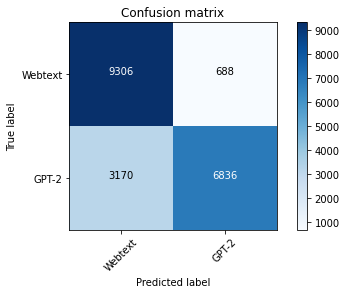

In [0]:
loss, acc, fscore, cm, cr = evaluate_confusion_matrix(best_model, test_iter, loss_func)
print("Overall f-score:", round(fscore, 4))
print("Classification report:")
print(cr)

plot_confusion_matrix(cm, ("Webtext", "GPT-2"))

My evaluation:
- Overall, the best CNN model did well on the test set, predicting about 80% of the data correctly (16142 out of 20000). In terms of error, the model had a tougher time correclty detecting GPT-2 generated text. Actually, 82% of the wrong predictions were categorizing GPT-2 text as Webtext (3170/3858). I suspect two reasons for this result: (1) there is a subset of GPT-2 data that is (coincidentally?) very well generated and mimics human text, or (2) the shorter lengthed GPT-2 text is harder to categorize. 

In [0]:
test_string1 = "Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud\n\nJuly 6, 2018"

test_string2 = "Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion."

test_string3 =  long_string

test_string4 = long_string2

test_string5 = "Scientists can now visualize and experiment with structures and the dynamics of complex molecular makeup (at atomic-level precision), with real-time multi-user collaboration via the cloud\n\nJuly 6, 2018"

test_string6 = "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance reforms. We focus mainly on interventions aimed at improving primary and secondary education but consider vocational training interventions briefly. We have not yet completed a report on early childhood (pre-school) interventions. On this page, we focus on evidence from experimental study designs."

test_string7 = "If you look on a board game shelf, how many games will you see with actions based on collaboration, stewardship, generosity, and gratitude? Most likely, you'll find mechanics like attacking, stealing, and backstabbing. Indigenous communities looking to facilitate intergenerational gameplay are thus hard-pressed to find options that reinforce their teachings. In response, communities are developing their own games for passing on teachings in many forms. As espoused by game designer Brenda Romero, the mechanic is the message. And the messages in the board game The Gift of Food—inspired by collaborative game development with Indigenous communities working with the Northwest Indian College—produce culturally responsive gameplay, meaning gameplay that is drawn from and that uplifts the cultures involved.\n\nThe Gift of Food is an ideal example of how culturally responsive board games can function as important pathways for passing on Indigenous ways of knowing"

test_strings_list = [test_string1, test_string2, test_string3, test_string4, test_string5, test_string6, test_string7]

test_strings_list2 = [test_string1, test_string2, test_string3, test_string4]

In [0]:
i=1
for each in test_strings_list:
  preprocessed = TEXT.preprocess(each)
  tensored = TEXT.process([preprocessed], device=device)
  best_model.eval()
  output = best_model(tensored)
  probabilities, predicted = torch.max(output.cpu().data, 1)
  print(f"GPT-2_string_{i} is {len(preprocessed)} words long.")
  print(f'The text: "{each}"')
  print(f"The prediction for GPT-2_string_{i} is {predicted.item()} and the model was {round(probabilities.item(), 4)}% confident.")
  print("----------")
  i+=1


GPT-2_string_1 is 38 words long.
The text: "Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018"
The prediction for GPT-2_string_1 is 1 and the model was 0.6872% confident.
----------
GPT-2_string_2 is 42 words long.
The text: "Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion."
The prediction for GPT-2_string_2 is 1 and the model was 0.8143% confident.
----------
GPT-2_string_3 is 169 words long.
The text: "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) r

My analysis:
* As previous works have pointed out, short sentences are harder to detect. This CNN model found the same, making wrong predictions for the shorter sentences. Interestingly, the model was not as confident with its prediction for string_1 though.
* String_1 analysis: I managed to increase the model's prediction probability to 74% by making the sentence a bit more fluent by adding one "the" and removing a repeated word, replacing the second "structure" with "makeup". I also experimented with the punctuations and but found that they did not make a difference in the model's probability. I also removed the date during my trial-and-error and found it made no difference to the model. The biggest gain in probability comes from removing the repeated word.
* String_4 analysis: having established that repeated words appear to be an indicator for synthetic text detection for a CNN model, this string actually has a few repeated sentences. Hence, the model confidently predicted it is GPT-2 generated. I removed the repetition in string_6, which also shortened the sentence, and the model then made the wrong prediction, thinking string_6 is human-generated.
* String_5 analysis: I think the model correctly predicted this document because it lacks coherence. Even though the document is more or less grammatically correct, the topics include boardgames, Indigenous communities, cultural values, a specific board game that is oddlyl named. I tried using this example to see how short it needed to be for the model to make a wrong prediction. I simply deleted one sentence at a time to see how the CNN responded and I was surprised to find I had to truncate the document to one sentence (i.e., 28 words long) in order to fool the model. There is definitely some features in this document that makes the model very confident it is synthetically produced.
* From my personal analysis as a linguist, I actually agree with the CNN model's predictions, even the wrong ones. When I read the short sentences (string_1 and string_2), even though I think that string_1 is worded a little awkwardly, overall I would be unsure if it was synthetic text or not. 



# Model interpretability from tutorial

In [0]:
def S(model, token_tensor, erase_tokenid, gold_label_id):
    '''
    input:
    i) trained_model - trained CNN model on IMDB dataset
    ii) token_tensor - tensor containing token ids for a test sample 'e'
    iii) erase_tokenid - id corresponding to the token to be erased. -1 if no token needs to be erased (useful in computing S(e,c))
    iv) gold_label_id - gold sentiment label for the test sample 'e'
    
    returns:
    probability by model to the gold label. S(e,c) if erase_tokenid == -1 else S(e,c,~d)
    '''
    
        # input_embeddings = self.embeddings(x)  
        # # (batch size, word_sequence, embedding_dim) word embedding

        # input_embeddings = input_embeddings.permute(1,0,2)
        # input_embeddings = input_embeddings.unsqueeze(1)
        # #  [batch size, number of channel is one, sequence length, embeeding size]

        # # convolutional layers
        # convolute_outputs = [F.relu(conv(input_embeddings)).squeeze(3) for conv in self.convolution_layers]  
        
        # # to get the maximum value of filtered tensor
        # max_pooling_outputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in convolute_outputs] 
        
        # concat_list = torch.cat(max_pooling_outputs, 1) # concatenate representations
        
        # drop_output = self.dropout(concat_list)  # add drop layer
        
        # fc1_output = self.fc(drop_output)  # get the fc1 using a fully connected layer
        
        # final_output = F.softmax(fc1_output,dim=1)

    #token_tensor = [1, sent len]  note: batch_size is 1
    embedded = model.embeddings(token_tensor.permute(1,0).to(device))
    #embedded = [batch size, sent len, emb dim]


    # check if word embedings corresponding to a token has to be erased
    if erase_tokenid != -1:
        embedded[0, erase_tokenid, :].fill_(0.0)
    #embedded = [batch size, sent len, emb dim]

    #embedded = [batch size, sent len, emb dim]
    embedded = embedded.unsqueeze(1)
    #print("embedded", embedded.shape)
    #embedded = [batch size, 1, sent len, emb dim]

    conved = [F.relu(conv(embedded)).squeeze(3) for conv in model.convolution_layers]
    #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    #pooled_n = [batch size, n_filters]

    cat = model.dropout(torch.cat(pooled, dim = 1))
    #cat = [batch size, n_filters * len(filter_sizes)]

    probability =  torch.softmax(model.fc(cat), dim=1)

    return probability[0,gold_label_id].item() 


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import altair as alt

def interpret_sentence(sentence, min_len = 5, true_label = 1):
  '''
  input:
  i) sentence - the sample sentence to be analyzed
  ii) min_len - minimum length of the sentence (alternatively, maximum width of the filter used by the orginal author)
  iii) true_label - gold sentiment label for the sample sentence to be analyzed
  returns:
  None (actually the code plots the heatmap and returns nothing)
  '''
  # # tokenize sentence
  # token_ids = [TEXT.vocab.stoi[tok.text] for tok in nlp.tokenizer(sentence)]
  # # pad the sentence if necessary
  # if len(token_ids) < 5: # where 5 in min_len
  #   token_ids += [TEXT.vocab.stoi['pad']] * (5 - len(token_ids))
  
  # # convert to tensor
  # token_tensor = torch.tensor(token_ids, device=device).unsqueeze(0)
  
  
  preprocessed = TEXT.preprocess(sentence) #tokenize
  token_tensor = TEXT.process([preprocessed], device=device) #tensored
    
  # get prediction
  #prediction = round(torch.sigmoid(best_model(token_tensor)).item())
  best_model.eval()
  output = best_model(token_tensor)
  probabilities, prediction = torch.max(output.cpu().data, 1)

   
  # get word importance
  tokens, imp_scores = [None], []
  s_ec = S(best_model, token_tensor, -1, true_label)
  for t_i, token_id in enumerate(token_tensor):
    if token_id != TEXT.vocab.stoi['pad']: # we don't need to calculate importance score for pad tokens (seriously?)
      s_e = S(best_model, token_tensor, t_i, true_label)
      tokens.append(TEXT.vocab.itos[token_id])
      imp_scores.append([((s_ec-s_e)/s_ec)])
  
  # plot the heatmap and other values
  print('sentence = %s'%sentence)
  print('predicted label = %d; gold label = %d'%(prediction, true_label))
  fig, ax = plt.subplots()
  print(imp_scores)
  print(tokens)
  im = ax.imshow(np.array(imp_scores).transpose(), cmap=plt.cm.Blues)
  ax.set_xticklabels(tokens)
  ax.set_yticklabels(['importance'])
  plt.colorbar(im)
  fig.tight_layout()
  plt.show()


sentence = Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018
predicted label = 1; gold label = 0
[[0.008620489224602864], [0.04814444467313244], [0.020235361872070413], [-0.030916996930244824], [0.07057787931524716], [0.0], [0.059435247375614696], [0.0], [0.10718939787213444], [0.0050027404444627395], [0.11418191443867388], [-0.06894962079719111], [-0.10529538484759089], [0.025544830088631842], [0.040149893545738745], [0.01628782594709227], [0.0], [-0.13650748457690054], [0.03581920994396382], [0.07279234139153595], [0.025779807002578838], [0.0], [-0.0014086227570472112], [0.020426983353800908], [0.0445092584334415], [-0.0014086227570472112], [0.0], [-0.11097494646795204], [-0.05713102526163812], [-0.1278541214531445], [-0.07711721250679394], [-0.4254217959478012], [-0.08736405451616862], [0.0022820203212151565], [-0.0849986583637679], 

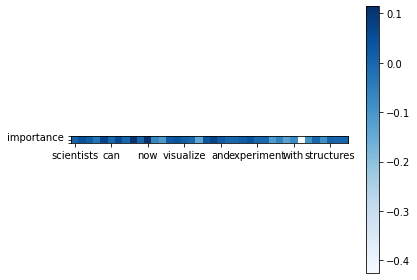

In [0]:
interpret_sentence(test_string1, true_label=0)

sentence = Scientists can now visualize and experiment with structures and the dynamics of complex molecular makeup (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018
predicted label = 1; gold label = 0
[[0.009303396618317056], [0.05219832048721685], [0.02181824529246744], [-0.0313161947998082], [0.08369086135488343], [0.0], [0.013724128396121242], [0.0], [0.16428638971336568], [-0.003032967408980922], [0.008631651616465163], [-0.27410455963537345], [-0.04913795614733954], [-0.32479489293464364], [-0.15775476486959755], [-0.06638935269722207], [0.00891822120166407], [0.0], [-0.15960469349885859], [0.03857302912027877], [0.08049958130091263], [0.02778407149373616], [0.0], [-0.0015216278539625673], [0.022024358067945313], [0.04286579295503528], [-0.0015216278539625673], [0.0], [-0.12644030405275747], [-0.08254348482487465], [-0.12078844436758404], [-0.10494319240598692], [-0.4762267467104031], [-0.09501429033163465], [-0.02110153233230882], [

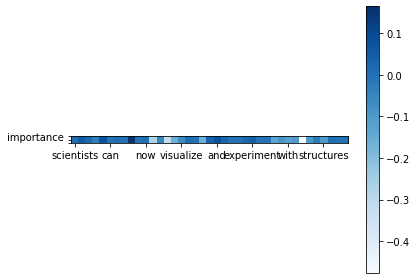

In [0]:
interpret_sentence(test_string5, true_label=0)

In [0]:
import numpy as np
import altair as alt

def interpret_sentence_altair(sentence, min_len = 5, true_label = 1):
  '''
  input:
  i) sentence - the sample sentence to be analyzed
  ii) min_len - minimum length of the sentence (alternatively, maximum width of the filter used by the orginal author)
  iii) true_label - gold sentiment label for the sample sentence to be analyzed
  returns:
  None (actually the code plots the heatmap and returns nothing)
  '''
  # # tokenize sentence
  # token_ids = [TEXT.vocab.stoi[tok.text] for tok in nlp.tokenizer(sentence)]
  # # pad the sentence if necessary
  # if len(token_ids) < 5: # where 5 in min_len
  #   token_ids += [TEXT.vocab.stoi['pad']] * (5 - len(token_ids))
  
  # # convert to tensor
  # token_tensor = torch.tensor(token_ids, device=device).unsqueeze(0)
  
  
  preprocessed = TEXT.preprocess(sentence) #tokenize
  token_tensor = TEXT.process([preprocessed], device=device) #tensored
    
  # get prediction
  #prediction = round(torch.sigmoid(best_model(token_tensor)).item())
  best_model.eval()
  output = best_model(token_tensor)
  probabilities, prediction = torch.max(output.cpu().data, 1)

   
  # get word importance
  tokens, imp_scores = [None], []
  s_ec = S(best_model, token_tensor, -1, true_label)
  for t_i, token_id in enumerate(token_tensor):
    if token_id != TEXT.vocab.stoi['pad']: # we don't need to calculate importance score for pad tokens (seriously?)
      s_e = S(best_model, token_tensor, t_i, true_label)
      tokens.append(TEXT.vocab.itos[token_id])
      imp_scores.append([((s_ec-s_e)/s_ec)])

  tokens_scores = pd.DataFrame(
    {'tokens': tokens[1:],
     'scores': imp_scores,
    })
  
  tokens_scores["tokens_index"] = list(tokens_scores["tokens"].index)
  tokens_scores['tokens_index'] = tokens_scores.tokens_index.astype(str)
  tokens_scores["tokens_index"] = tokens_scores["tokens"].str.cat(tokens_scores["tokens_index"], sep="_")
  
  viz = alt.Chart(tokens_scores).mark_rect().encode(
    x=alt.X('tokens_index:O', sort=None),
    color="scores:Q" 
  )
  
  print('sentence = %s'%sentence)
  print('predicted label = %d; gold label = %d'%(prediction, true_label))

  return viz

  # # plot the heatmap and other values
  # print('sentence = %s'%sentence)
  # print('predicted label = %d; gold label = %d'%(prediction, true_label))
  # fig, ax = plt.subplots()
  # im = ax.imshow(np.array(imp_scores[:15]).transpose(), cmap=plt.cm.Blues)
  # ax.set_xticklabels(tokens[:15])
  # ax.set_yticklabels(['importance'])
  # plt.colorbar(im)
  # fig.tight_layout()
  # plt.show()


In [0]:
interpret_sentence_altair(test_string5, true_label=0)

       tokens                  scores  tokens_index
0  scientists  [0.009303396618317056]  scientists_0
1         can   [0.05219832048721685]         can_1
2         now   [0.02181824529246744]         now_2
3   visualize   [-0.0313161947998082]   visualize_3
4         and   [0.08369086135488343]         and_4
sentence = Scientists can now visualize and experiment with structures and the dynamics of complex molecular makeup (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018
predicted label = 1; gold label = 0


alt.Chart(...)

In [0]:
interpret_sentence_altair(test_string1, true_label=0)

       tokens                   scores  tokens_index
0  scientists   [0.008620489224602864]  scientists_0
1         can    [0.04814444467313244]         can_1
2         now   [0.020235361872070413]         now_2
3   visualize  [-0.030916996930244824]   visualize_3
4         and    [0.07057787931524716]         and_4
sentence = Scientists can now visualize and experiment with structures and dynamics of complex molecular structures (at atomic-level precision), with real-time multi-user collaboration via the cloud

July 6, 2018
predicted label = 1; gold label = 0


alt.Chart(...)

In [0]:
interpret_sentence_altair(test_string2, true_label=0)

     tokens                   scores tokens_index
0       pro    [-0.0915214968375158]        pro_0
1      tour  [-0.021189719206575735]       tour_1
2  amonkhet    [0.22872924905561923]   amonkhet_2
3        is    [-0.6577880485728306]         is_3
4       now    [0.05153265514849988]        now_4
sentence = Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion.
predicted label = 1; gold label = 0


alt.Chart(...)

In [0]:
interpret_sentence_altair(test_string3, true_label=0)

    tokens                    scores tokens_index
0  summary  [-0.0008603524635640553]    summary_0
1    focus  [-0.0021342603074121207]      focus_1
2       of                     [0.0]         of_2
3     this                     [0.0]       this_3
4     page                     [0.0]       page_4
sentence = Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance reforms. We focus mainly on interventions aimed at improving primary and secondary education but consider vocational training interventions briefly. We have not yet completed a report on early childhood (pre-school) interventions. On this page, we focus on evidence from experimental study designs.\n\nThis page discusses our cur

alt.Chart(...)

In [0]:
interpret_sentence_altair(test_string4, true_label=0)

  tokens                    scores tokens_index
0     if                     [0.0]         if_0
1    you                     [0.0]        you_1
2   look   [7.023970817940782e-05]       look_2
3     on   [0.0013304664300649736]         on_3
4      a  [-0.0022591295206592075]          a_4
sentence = If you look on a board game shelf, how many games will you see with actions based on collaboration, stewardship, generosity, and gratitude? Most likely, you'll find mechanics like attacking, stealing, and backstabbing. Indigenous communities looking to facilitate intergenerational gameplay are thus hard-pressed to find options that reinforce their teachings. In response, communities are developing their own games for passing on teachings in many forms. As espoused by game designer Brenda Romero, the mechanic is the message. And the messages in the board game The Gift of Food—inspired by collaborative game development with Indigenous communities working with the Northwest Indian College—produc

alt.Chart(...)

In [0]:
from tqdm import tqdm

def compute_word_importance(input_model, data_iter, top_k=20):
    '''
    input:
    i) data_iter - iterator over the training examples 
    ii) top_k - number of most and less important words to output
    return:
    i) top_k most important words
    ii) top_k least important words
    '''
    model = input_model
    # bookkeeping
    word2Sscore = {} # stores word to sum of probability scores
    word2count = {} # stores word to number of examples containing this word
    
    inst_i =0
    # run over training examples
    for batch in data_iter:
      input, label = batch.text, batch.label
      s_ec = S(model, input, -1, label) # no erasing
      # run over all the words in the input
      for t_i, token_id in enumerate(input):
        s_e = S(model, input, t_i, label) # erase a token
        token_str = TEXT.vocab.itos[token_id]
        if token_str not in word2Sscore:
          word2Sscore[token_str] = 0
          word2count[token_str] = 0
        word2Sscore[token_str] += (s_ec - s_e)/s_ec
        word2count[token_str] += 1
      inst_i += 1
      if inst_i > 500:
       break
    
    # compute importance score
    word2impscore = {}
    for token_str in word2Sscore:
      word2impscore[token_str] = word2Sscore[token_str] / word2count[token_str]
    
    # sort the words based on importance
    words_to_be_sorted = []
    for word in word2impscore:
      words_to_be_sorted.append((word2impscore[word], word))
    sorted_words = sorted(words_to_be_sorted) # sorts in ascending order in increasing order of importance
    
    # pick the top k as least important  - lower the importance score lesser the importance 
    least_important_words = []
    for word in sorted_words:
      least_important_words.append((word[1], word[0]))
      if len(least_important_words) == top_k:
        break
    
    # sort the words based on decreasing order of importance and pick the top k as most important
    sorted_words.reverse()
    most_important_words = []
    for word in sorted_words:
      most_important_words.append((word[1], word[0]))
      if len(most_important_words) == top_k:
        break
    
    return most_important_words, least_important_words  

# create an iterator over instances (usually done with train instances)
#test_subset, _ = test_full.split(split_ratio=0.1)
validation_iter = torchtext.data.BucketIterator(dataset=val, batch_size = 1)

# train_iter, val_iter = BucketIterator.splits( 
#  (train, val), 
#  batch_sizes=(64,256),
#  sort_key=lambda x: len(x.text), 
#  sort=True,
#  device=device,
#  sort_within_batch=True
# )




# identify the most and least important words
most_important_words, least_important_words = compute_word_importance(best_model, validation_iter)

In [0]:
print('most important words\nno.\tword\tscore')
for i, word_score in enumerate(most_important_words):
  print('%d\t%s\t%.2f'%(i+1, word_score[0], word_score[1]))

most important words
no.	word	score
1	pendleton	0.74
2	sandwiched	0.72
3	c'mon	0.69
4	leland	0.67
5	yeager	0.64
6	intermediate	0.62
7	weaves	0.61
8	aseptic	0.61
9	steered	0.61
10	straightening	0.60
11	ard	0.59
12	phys	0.57
13	drifted	0.56
14	cling	0.54
15	burgeoning	0.54
16	spirited	0.54
17	squeezed	0.54
18	integer	0.54
19	eradicating	0.53
20	800,000	0.52


In [0]:
print('least important words\nno.\tword\tscore')
for i, word_score in enumerate(least_important_words):
  print('%d\t%s\t%.2f'%(i+1, word_score[0], word_score[1]))

least important words
no.	word	score
1	cooke	-12.57
2	unsigned	-4.37
3	prev	-1.52
4	mick	-1.10
5	laird	-1.01
6	mel	-0.89
7	capito	-0.82
8	536	-0.79
9	bsi	-0.71
10	pepe	-0.70
11	strictly	-0.69
12	2,066	-0.68
13	1,065	-0.63
14	secularist	-0.61
15	melton	-0.58
16	intersex	-0.57
17	ticking	-0.54
18	853	-0.52
19	vigo	-0.52
20	agnostic	-0.51
